# Leaky Integrate and Fire (LIF) Tutorial
__Authors:__ Antoine de Comite and Florence Blondiaux

__Content inspired from__: Neuromatch Academy github.com/NeuromatchAcademy

Please run the cells below to initialize the notebook.

In [1]:
#Useful libraries
import numpy as np
import matplotlib.pyplot as plt



In [2]:
# @title Figure Settings
import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
my_layout = widgets.Layout()

plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

---
## Tutorial Objectives
 In this tutorial, we will build up a leaky integrate-and-fire (LIF) neuron model and study its dynamics in response to various types of inputs. In particular, we are going to write a few lines of code to:  

- simulate the LIF neuron model

- drive the LIF neuron with external inputs, such as direct currents, Gaussian white noise, sinusoidal currents, ...
- study how different inputs affect the  LIF neuron's output (firing rate and spike time irregularity)

Here, we will especially emphasize identifying conditions (input statistics) under which a neuron can spike at low firing rates and in an irregular manner. The reason for focusing on this is that in most cases, neocortical neurons spike in an irregular manner.


---
 <font color='red'> If you are working in google colab, in order to save your work, go to File > "Save a copy in Drive" and work on the copy. If you don't do this, you will loose all your modifications when you close the tab ! </font>


---
## Reminder

A *membrane equation* and a *reset condition* define our *leaky-integrate-and-fire (LIF)* neuron:


\begin{equation*}
\tau_m \frac{du}{dt} = -\left(u(t)-u_{rest}\right) +RI(t)  \;\;\; if \; u(t)\leq \theta
\end{equation*}
\begin{equation*}
u(t) = u_{reset}  \;\;\;\;\;\;\;\;\;  otherwise
\end{equation*}


The membrane equation is an *ordinary differential equation (ODE)* that describes the time evolution of membrane potential $u(t)$ in response to synaptic input and leaking of change across the cell membrane. To find an approximation of the solution of this ODE, you can use explicit Euler integration over one time step.
Euler integration :
\begin{equation*}
\frac{dX(t)}{dt} \simeq \frac{X(t+\Delta t) - X(t)}{\Delta t}
\end{equation*}

## Synaptic input

We start with a sinusoidal model to simulate the synaptic input $I(t)$ given by:
\begin{align*}
\\
I(t)=I_{mean}\left(1+\sin\left(\frac{2 \pi}{0.01}\,t\right)\right)\\
\\
\end{align*}

### Exercise 1
Compute the values of synaptic input $I(t)$

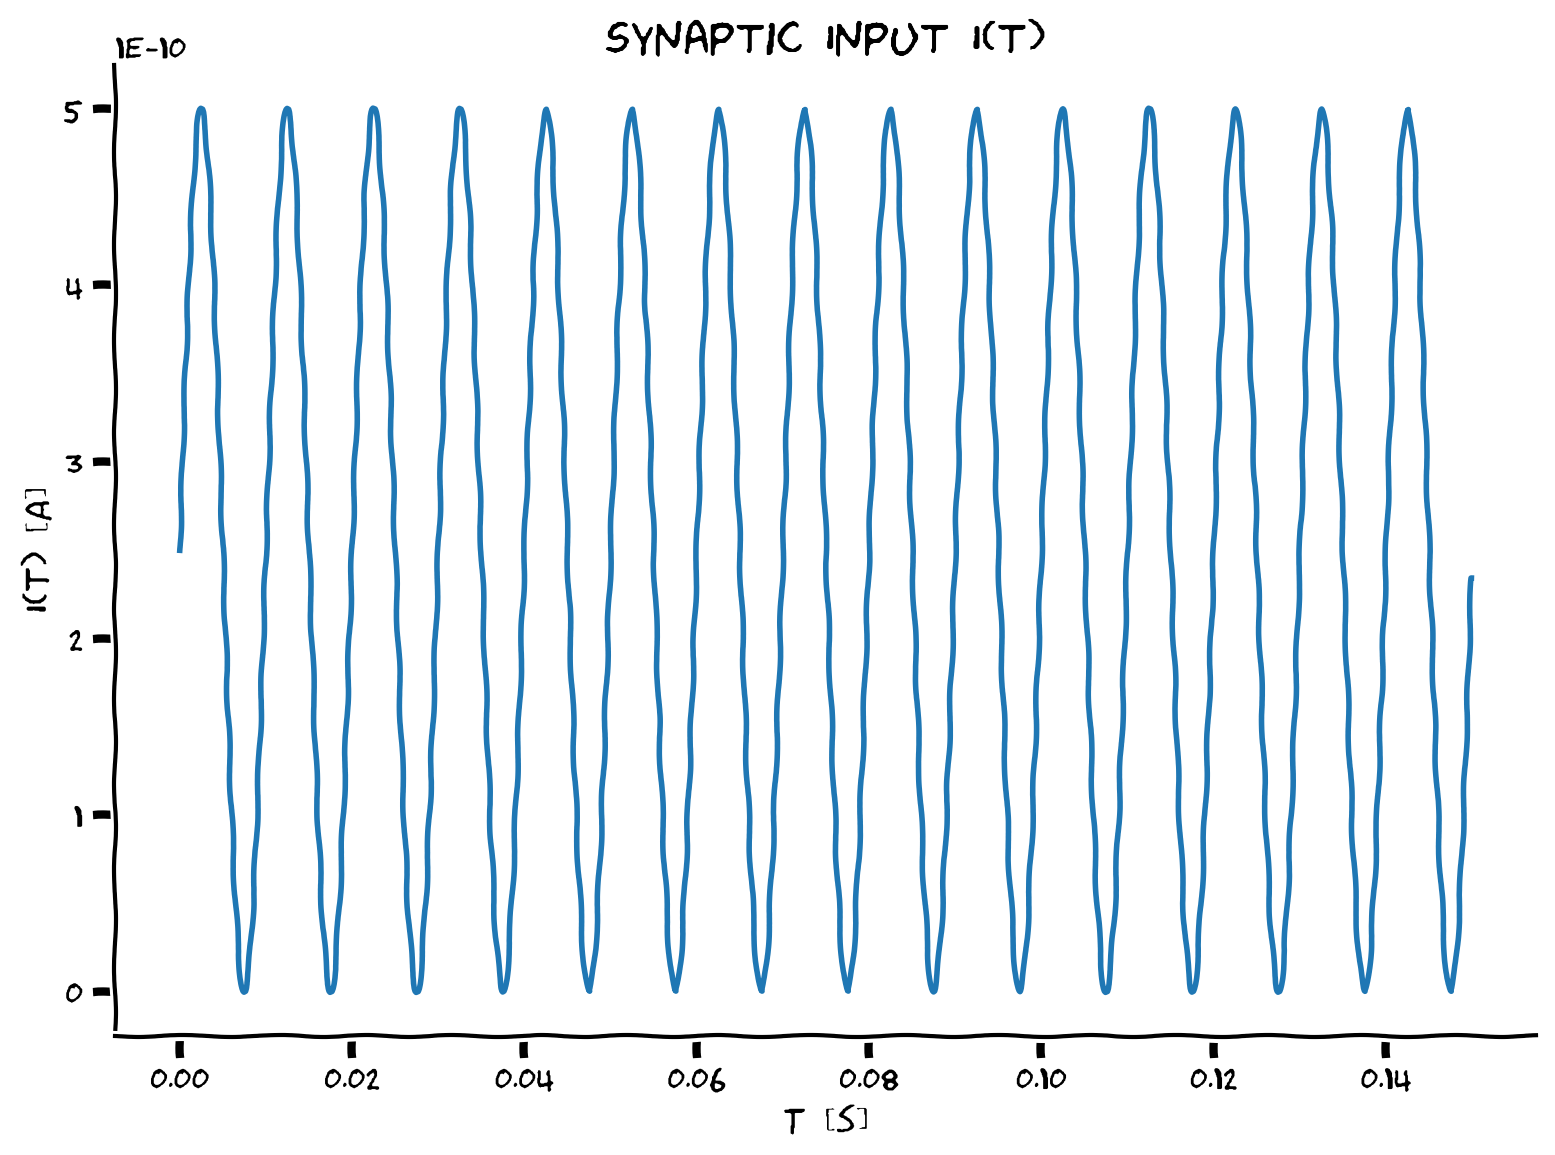

In [3]:
def syn_in(t, imean = 25e-11):
    """
    Function that produces sinusoidal input

    Args:
      t          : Vector of discretized time points (numpy array)
      imean      : current mean amplitude [A] (integer)

    Returns:
      sin_i       : Sinusoidal input current (numpy array)
    """
    sin_i = imean * (1 + np.sin((t * 2 * np.pi) / 0.01))
    return sin_i

t_max = 150e-3   # second
dt = .1e-3        # second
t_range = np.arange(0,t_max, dt)

with plt.xkcd():
    plt.plot(t_range,syn_in(t_range))
    plt.title("Synaptic Input I(t)")
    plt.xlabel('T [s]')
    plt.ylabel('I(t) [A]')
    plt.show()


*Example output:*

<img alt='Solution hint' align='left' width=413 height=300 src=https://raw.githubusercontent.com/fblondiaux/LGBIO2072-2020/master/Images/TP1-Ex1.png>

---
## ODE integration without spikes
In the next exercise, we now simulate the evolution of the membrane equation in discrete time steps, with a sufficiently small $\Delta t$.

**Start by writing an approximation for the time derivative $\dfrac{d}{dt}\,u(t)$ in discrete time** using discrete-time integration methods such as Euler method. See [Numerical methods for ordinary differential equations](https://en.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations) for additional details.

### Exercise 2
Implement the evolution of the membrane potential in response to an input_current. Use the synusoidal input you just coded but try also with a step current as an input.

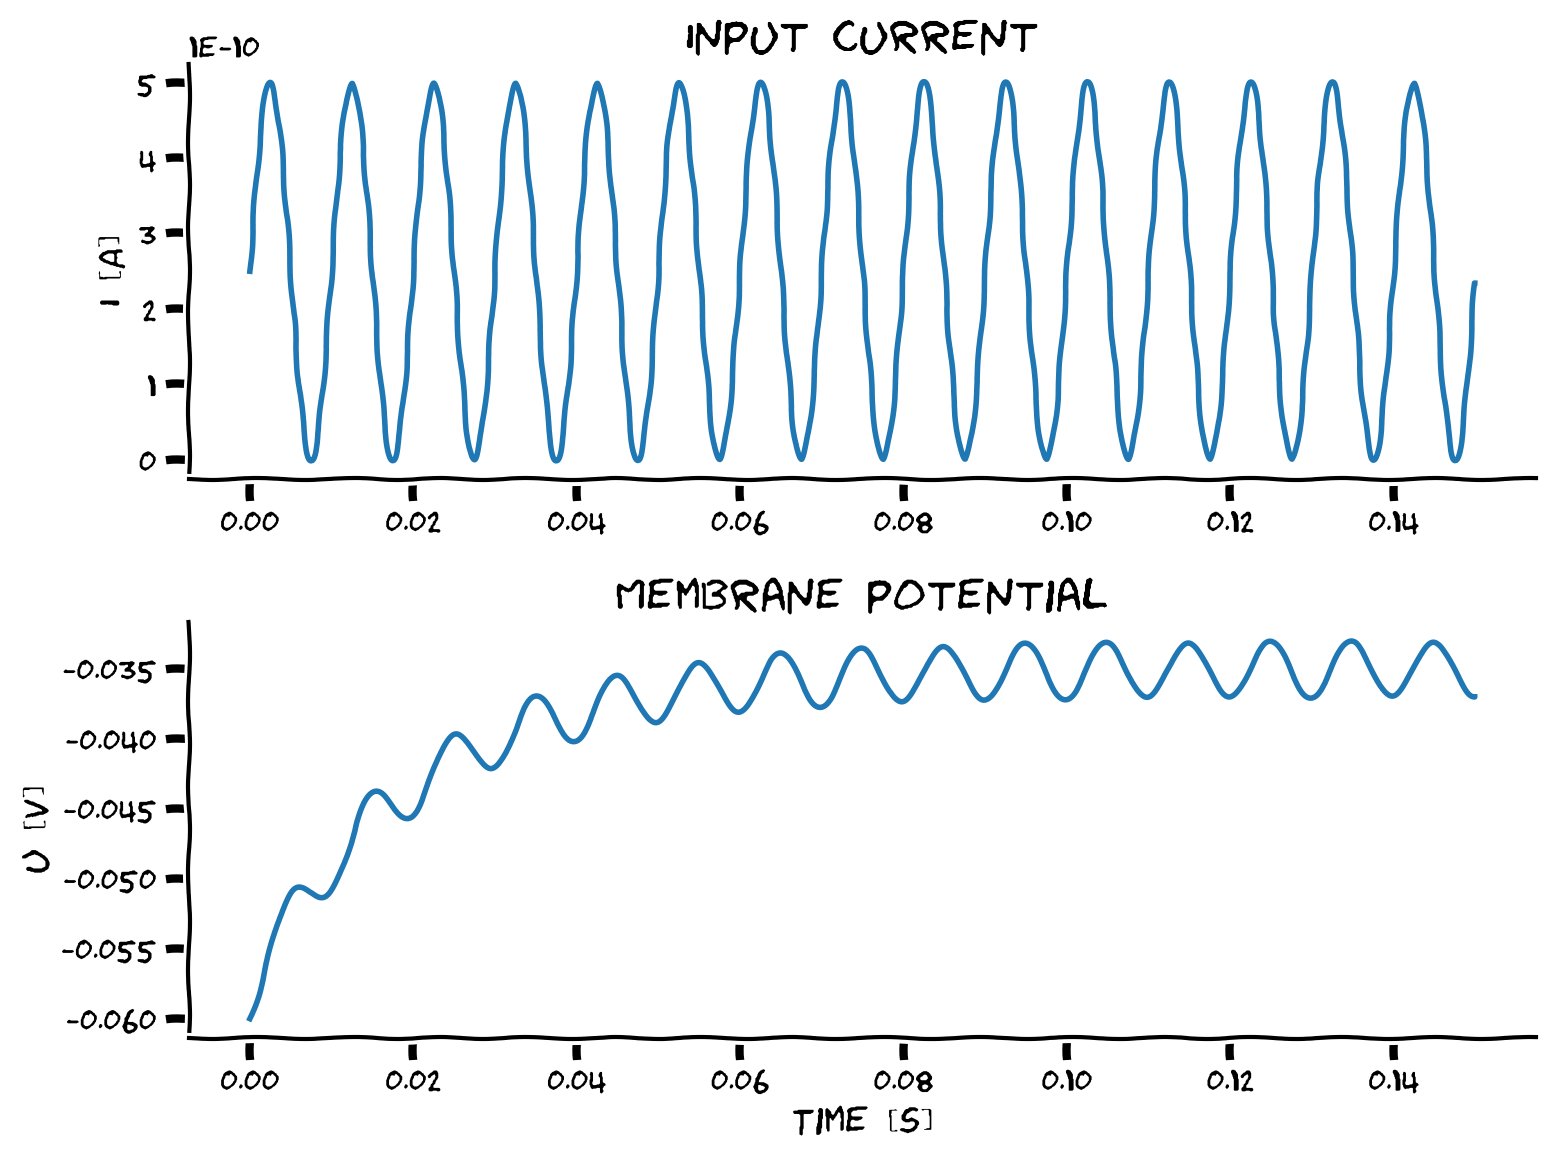

In [4]:
def membranePot(input_current, t, tau= 20e-3 , urest= -60e-3 , r= 100e6):
    """
    Authors : Antoine de Comite and Florence Blondiaux
    Simulate the integration of the membrane potential with external input current

    Args:
      input_current   : Vector containing the input current [A].
      t               : Vector containing the discretized time points [s].
      tau             : Membrane time constant. Default value: 20e-3 [s]
      urest           : Leak potential. Default value: -60e-3 [V]
      r               : Leak resistance. Default value: 100e6 [Ohm]
    Returns:
      u               : membrane potential [V]
    """
    dt = t[1]-t[0]
    u = np.zeros(len(input_current))
    u[0]=urest
    for step in range(len(input_current)-1):
        u[step+1]=u[step] + dt/tau * ( -u[step] + urest +r* input_current[step+1])
    return u

#Generates a random input current
t_max = 150e-3   # second
dt = .1e-3        # second
t_range = np.arange(0,t_max,dt)
input_current = syn_in(t_range)
u = membranePot(input_current, t_range)

with plt.xkcd():
    fig, axs = plt.subplots(2)
    axs[0].plot(t_range,input_current)
    axs[0].set(title = "Input current", ylabel = "I [A]")
    axs[1].plot(t_range,u)
    axs[1].set(title = "Membrane potential", ylabel = "u [V]", xlabel= "Time [S]")
    plt.show()

*Example output:*


<img alt='Solution hint' align='left' width=413 height=300 src=https://raw.githubusercontent.com/fblondiaux/LGBIO2072-2020/master/Images/TP1-Ex2.png>

---
# Introduce spikes
A spike takes place whenever $u(t)$ crosses $\theta$. In that case, a spike is recorded and $u(t)$ resets to $u_{reset}$ value. This is summarized in the *reset condition*:
$$u(t) = u_{reset}\quad \text{ if } u(t)\geq \theta$$

For more information about spikes or action potentials see [here](https://en.wikipedia.org/wiki/Action_potential).


![spikes cartoon](https://raw.githubusercontent.com/fblondiaux/LGBIO2072-2020/master/Solutions/spikes_carton.png)

### Exercise 3
Add the spiking process to your LIF model

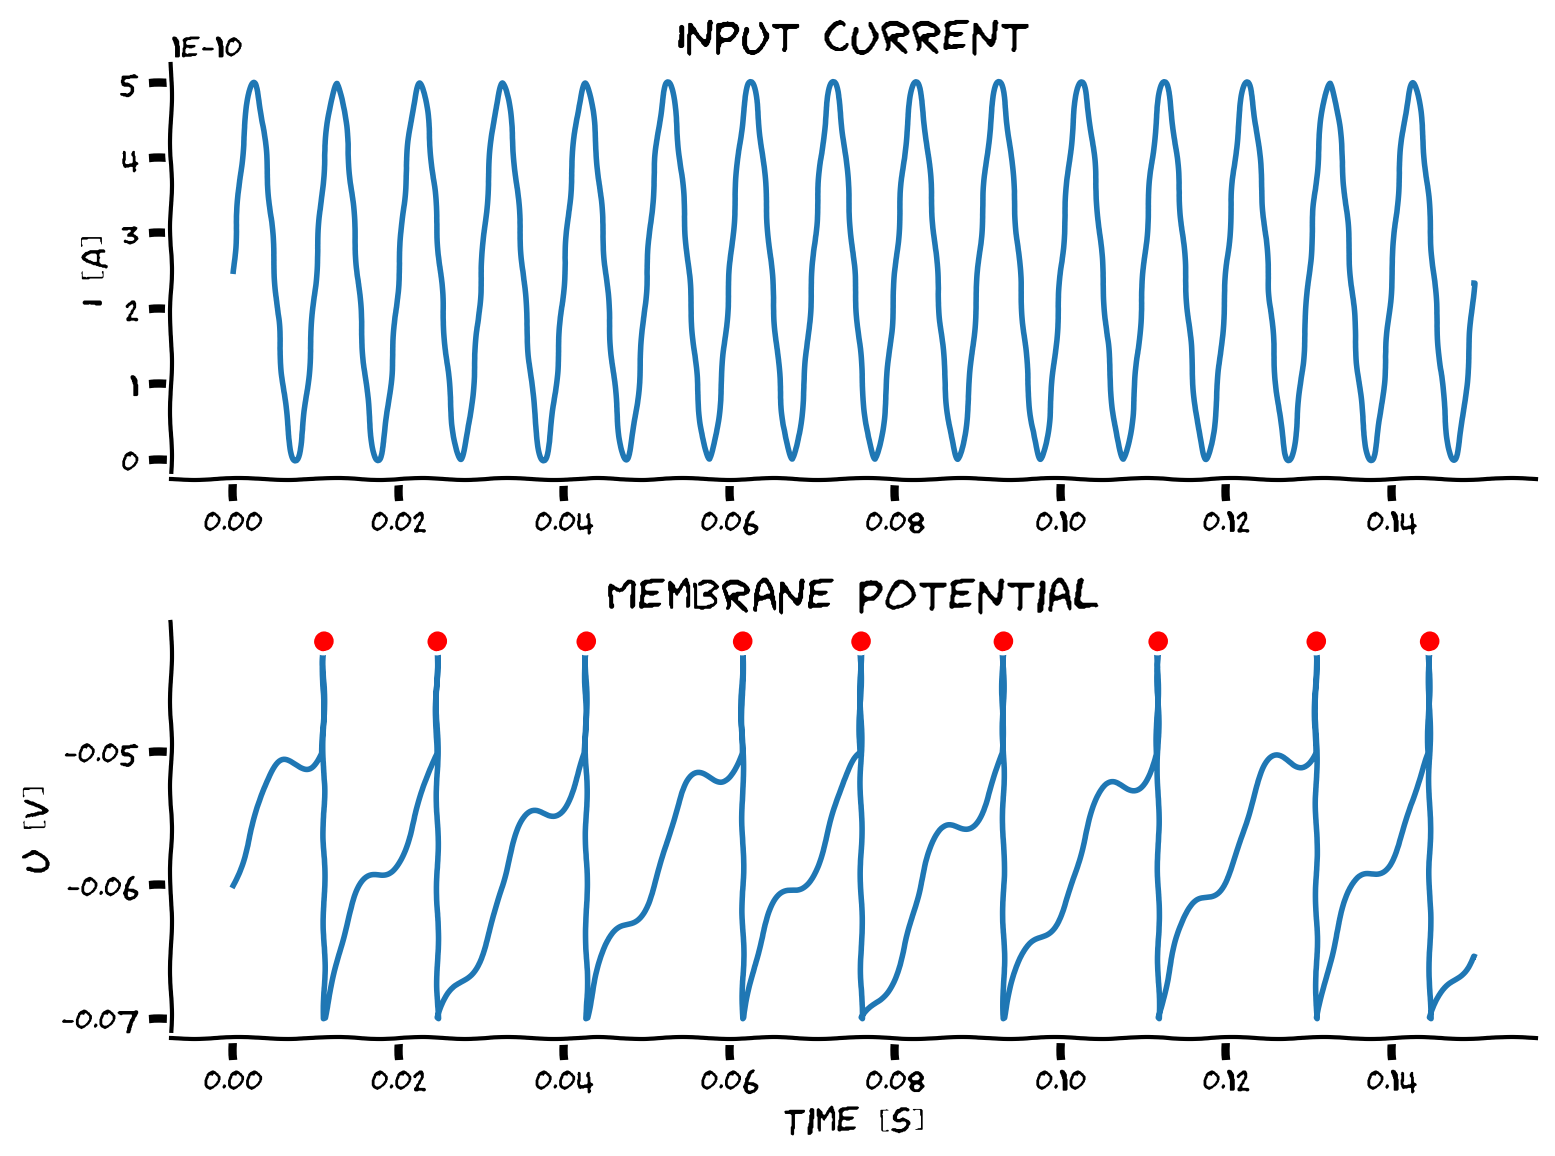

In [5]:
def simple_LIF(input_current,t,  tau= 20e-3 , urest= -60e-3 , r= 100e6, ureset = -70e-3 ,theta = -50e-3 ):
    """
    Authors : Antoine de Comite and Florence Blondiaux
    Simulate the integration of the membrane potential and the generation of spikes
    in response to an external input current

    Args:
      input_current   : Vector containing the input current [A].
      t               : Vector containing the discretized time points [s]
      tau             : Membrane time constant. Default value: 20e-3 [s]
      urest           : Leak potential. Default value: -60e-3 [V]
      r               : Leak resistance. Default value: 100e6 [Ohm]
      ureset          : Reset potential. Default value: -70e-3[V]
      theta           : Firing threashold. Default value: -50e-3 [V]
    Returns:
      u               : membrane potential [V]
      ts              : spike times [s]
    """
    ts = []
    dt = t[1]-t[0]
    u = np.zeros(len(input_current))
    u[0]=urest
    for step in range(0,len(input_current)-1):
        if u[step] > theta:
            u[step] = theta/1.2 #purely for cosmetic reasons (to have the straight line)
            u[step+1] = ureset
            ts.append(t[step])
        else:
            u[step+1]=u[step] -dt/tau * (u[step]-urest) + r*dt/tau * input_current[step]
    return u, ts

t_max = 150e-3   # second
dt = .1e-3       # second
t_range = np.arange(0,t_max,dt)
input_current = syn_in(t_range)
u ,ts = simple_LIF(input_current, t_range)

theta = -50e-3 #For red dots
with plt.xkcd():
    fig, axs = plt.subplots(2)
    axs[0].plot(t_range,input_current)
    axs[0].set(title = "Input current", ylabel = "I [A]")
    axs[1].plot(t_range,u)
    axs[1].plot(ts,np.ones(len(ts))*theta/1.2,'r.',markersize=12)
    axs[1].set(title = "Membrane potential", ylabel = "u [V]", xlabel= "Time [S]")
    plt.show()

*Example output:*


<img alt='Solution hint' align='left' width=413 height=300 src=https://raw.githubusercontent.com/fblondiaux/LGBIO2072-2020/master/Images/TP1-Ex3.png>

---
# Refractory period

The absolute refractory period is a time interval in the order of a few milliseconds during which synaptic input will not lead to a 2nd spike, no matter how strong. This effect is due to the biophysics of the neuron membrane channels, and you can read more about absolute and relative refractory period [here](https://content.byui.edu/file/a236934c-3c60-4fe9-90aa-d343b3e3a640/1/module5/readings/refractory_periods.html) and [here](https://en.wikipedia.org/wiki/Refractory_period_(physiology)).

![refractory period plot](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/python-for-nma/refractory_period.png)

### Exercise 4
Add the refractory period to your model

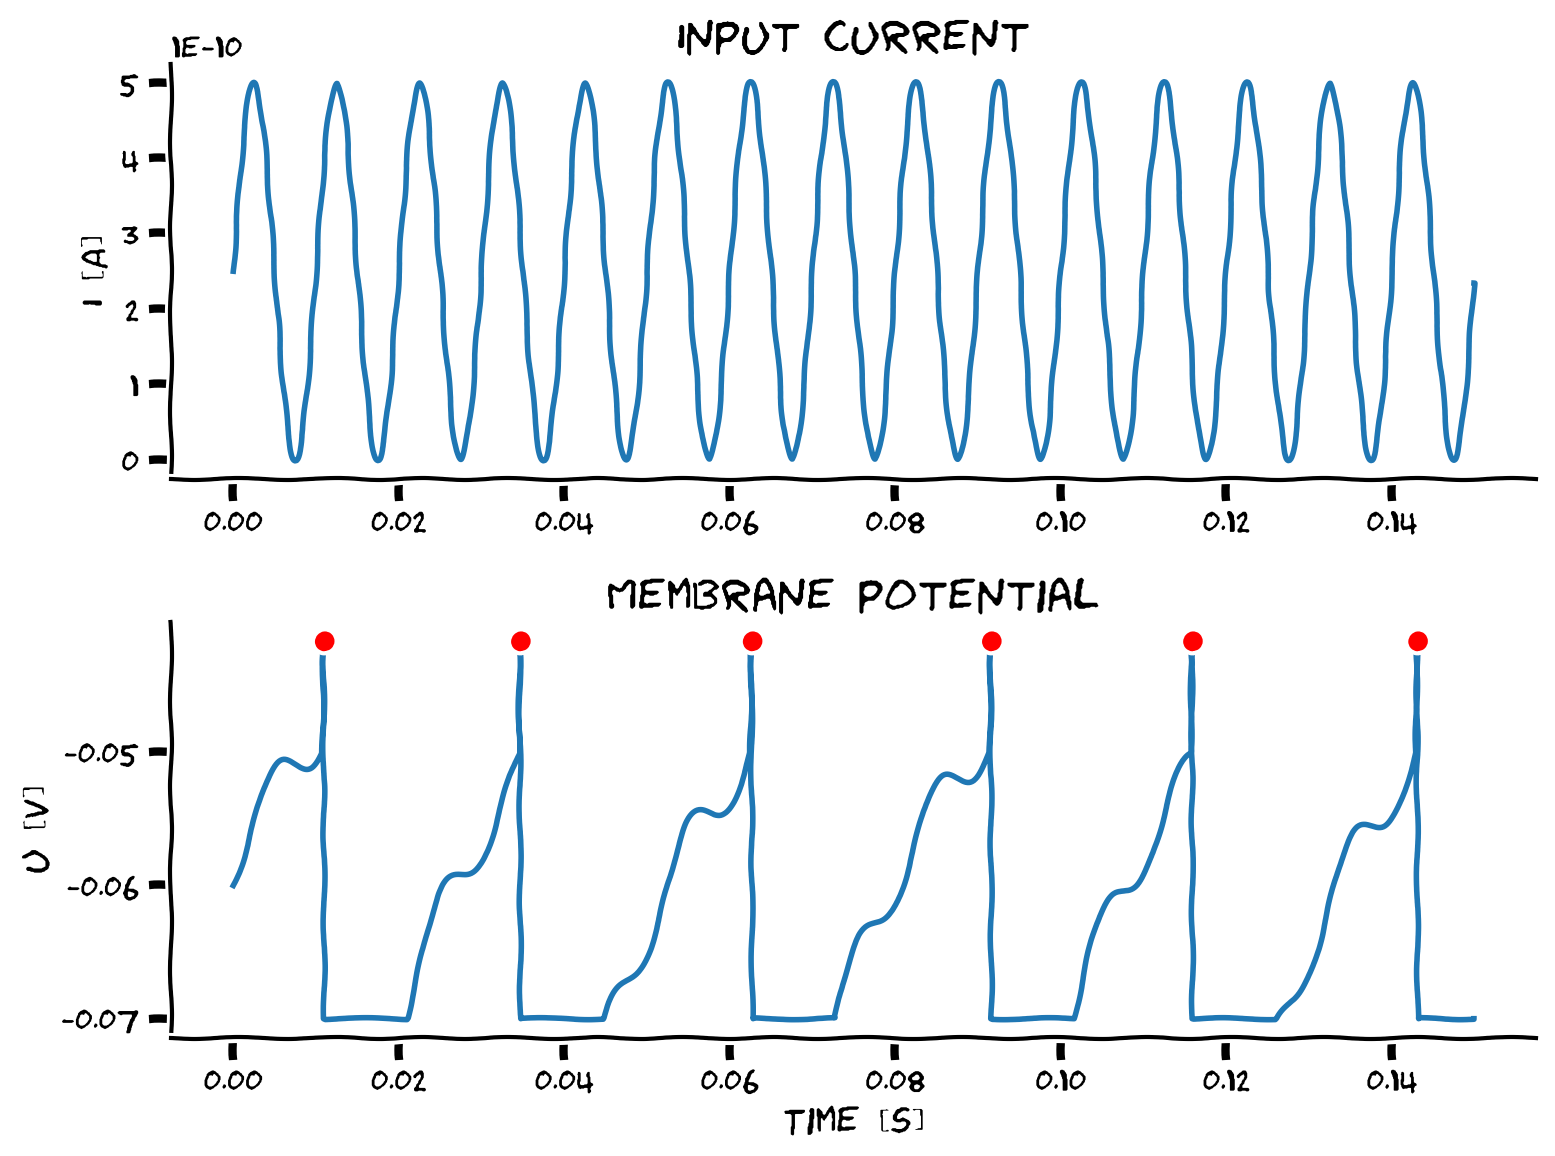

In [6]:

def LIF(input_current,t,  tau= 20e-3 , urest= -60e-3 , r= 100e6, ureset = -70e-3 \
               ,theta = -50e-3, t_ref = 10e-3 ):
    """
    Authors : Antoine de Comite and Florence Blondiaux
    Simulate the LIF model in response to an external input current

    Args:
      input_current   : Vector containing the input current [A].
      t               : Vector containing the discretized time points [s]
      tau             : Membrane time constant. Default value: 20e-3 [s]
      urest           : Leak potential. Default value: -60e-3 [V]
      r               : Leak resistance. Default value: 100e6 [Ohm]
      ureset          : Reset potential. Default value: -70e-3[V]
      theta           : Firing threashold. Default value: -50e-3 [V]
      t_ref           : Refractory period. Default value: 10e-3 [S]
    Returns:
      u               : membrane potential [V]
      ts              : spike times [s]
    """
    u = np.zeros_like(input_current)
    ts = []
    dt = t[1]-t[0]
    S = np.zeros_like(input_current)
    u[0]=urest
    t_wait = 0
    for step in range(0,len(input_current)-1):
        if u[step] > theta:
            u[step]= theta / 1.2
            u[step+1] = ureset
            t_wait = t_ref/dt
            ts.append((step+1)*dt)
        elif t_wait >0:
            u[step +1] = ureset
            t_wait -=1
        else:
            u[step+1]=u[step] -dt/tau * (u[step]-urest) + r*dt/tau * input_current[step]
    return u, ts

t_max = 150e-3   # second
dt = .1e-3        # second
t_range = np.arange(0,t_max,dt)
input_current = syn_in(t_range)
u,ts = LIF(input_current, t_range)

with plt.xkcd():
    fig, axs = plt.subplots(2)
    axs[0].plot(t_range,input_current)
    axs[0].set(title = "Input current", ylabel = "I [A]")
    axs[1].plot(t_range,u)
    axs[1].plot(ts,np.ones(len(ts))*-50e-3/1.2,'r.',markersize=12)
    axs[1].set(title = "Membrane potential", ylabel = "u [V]", xlabel= "Time [S]")
    plt.show()

Click [here](https://github.com/fblondiaux/LGBIO2072-2020/blob/master/Solutions/TP1-Ex4.py) for solution.

*Example output:*


<img alt='Solution hint' align='left' width=413 height=300 src=https://raw.githubusercontent.com/fblondiaux/LGBIO2072-2020/master/Images/TP1-Ex4.png>

### Exercise 5
Explore different values for LIF parameters. *tref* is expressed in [ms], *R* in [MOhm], *tau_m* in [ms] and *theta_th* in [mV].

In [ ]:
my_layout.width = '450px'
@widgets.interact(
    tref=widgets.FloatSlider(10, min=0, max=30, step=2, layout=my_layout),
    R=widgets.FloatSlider(100, min=10, max=200, step=10, layout=my_layout),
    tau_m = widgets.FloatSlider(20, min=5, max=40, step=2.5, layout=my_layout),
    theta_th = widgets.FloatSlider(-50, min=-55, max=-45, step=1, layout=my_layout)
)

def diff_tref(tref = 10e-3, R = 100, tau_m= 20, theta_th = -50):

    t_max = 150e-3   # second
    dt = .1e-3        # second
    t_range = np.arange(0,t_max,dt)
    input_current = syn_in(t_range)
    u,ts = LIF(input_current, t_range,t_ref = tref*1e-3, r=R*1e6, tau = tau_m *1e-3,theta = theta_th*1e-3 )

    fig, axs = plt.subplots(2)
    axs[0].plot(t_range,input_current)
    axs[0].set(title = "Input current", ylabel = "I [A]")
    axs[1].plot(t_range,u)
    axs[1].plot(ts,np.ones(len(ts))*-40e-3,'r.',markersize=12)
    axs[1].set(title = "Membrane potential", ylabel = "u [V]", xlabel= "Time [S]")
    plt.show()

---
## Random synaptic input
From the perspective of neurons, synaptic input is random (or stochastic). We'll improve the synaptic input model by introducing random input current with statistical properties similar to the previous exercise:

\begin{align*}
\\
I(t)=I_{mean}\left(1+0.1\sqrt{\frac{t_{max}}{\Delta t}}\,\xi(t)\right)\qquad\text{with }\xi(t)\sim \mathcal{N}(0,\sigma)\\
\\
\end{align*}

where $\mathcal{N}(0,\sigma)$ is the [gaussian distribution](https://en.wikipedia.org/wiki/Normal_distribution).

Random synaptic input $I(t)$ results in random time course for $u(t)$.

### Exercise 6
Implement a function that generates the input current given above


In [ ]:
def rand_syn(t,sigma = 0.1, imean = 25e-11):
    """
    Function that produces random input current

    Args:
      t          : vector of discretized time points
      imean      : current mean amplitude [A]
      sigma      : variance of the random input current

    Returns:
      sin_i       : Sinusoidal input current
    """
    dt = t[1]-t[0]
    rand_i = imean * (1 + 0.1 * (np.sqrt(np.max(t)/dt)) * np.random.normal(0,sigma,len(t)))
    return rand_i

t_max = 150e-3   # second
dt = .1e-3        # second
t_range = np.arange(0,t_max,dt)

with plt.xkcd():
    plt.plot(t_range,rand_syn(t_range))
    plt.title('Input current')
    plt.ylabel('I [A]')
    plt.xlabel('T [S]')
    plt.show()



*Example output:*


<img alt='Solution hint' align='left' width=413 height=300 src=https://raw.githubusercontent.com/fblondiaux/LGBIO2072-2020/master/Images/TP1-Ex6.png>

Once you have implemented the random input current, explore the effect different values of sigma have on the membrane potential

In [ ]:
# @title
# @markdown Make sure you execute this cell to enable the widget!
my_layout.width = '450px'
@widgets.interact(
    sigma=widgets.FloatSlider(0.8, min=0, max=5, step=0.2, layout=my_layout)

)

def diff_DC(sigma = 0.1):
    t_max = 150e-3   # second
    dt = 1e-3        # second
    t_range = np.arange(0,t_max,dt)
    input_current = rand_syn(t_range, sigma)
    u,ts = LIF(input_current, t_range)

    fig, axs = plt.subplots(2)
    axs[0].plot(t_range,input_current)
    axs[0].set(title = "Input current", ylabel = "I [A]")
    axs[1].plot(t_range,u)
    axs[1].plot(ts,np.ones(len(ts))*-40e-3,'r.',markersize=12)
    axs[1].set(title = "Membrane potential", ylabel = "u [V]", xlabel= "Time [S]")
    plt.show()

---
## Non-linear model of spiking
The cell below implements the model of Izhikevich. It is a non-linear model of spiking activity which reproduces several patterns that cannot be reproduced in the context of linear Leak-Integrate-and-Fire model including rich spiking and bursting dynamics exhibited by cortical
neurons.

The model is defined by two differential equations of the form
\begin{equation*}
v' = 0.004v^2 + 5v + 140 - u + I
\end{equation*}

\begin{equation*}
u' = a(bv-u)
\end{equation*}

with the auxilary after-spike resetting

\begin{equation*}
\text{if } v \geq 30mV, \text{then } v=c \text{ , }u=u+d
\end{equation*}

With $u(t)$ a membrane recovery variable which provides negative feedback to the membrane potential $v(t)$. $u(t)$ accounts for the activation of the $K^+$ ionic currents and the inactivation of $Na^+$ ionic currents. $v$ has mV scale.

The parameters a,b,c and d must be modified to produce specific patterns of activity. Details can be found here: https://www.izhikevich.org/publications/spikes.pdf

### Exercise 7

Using this information, implement the non-linear model of spiking

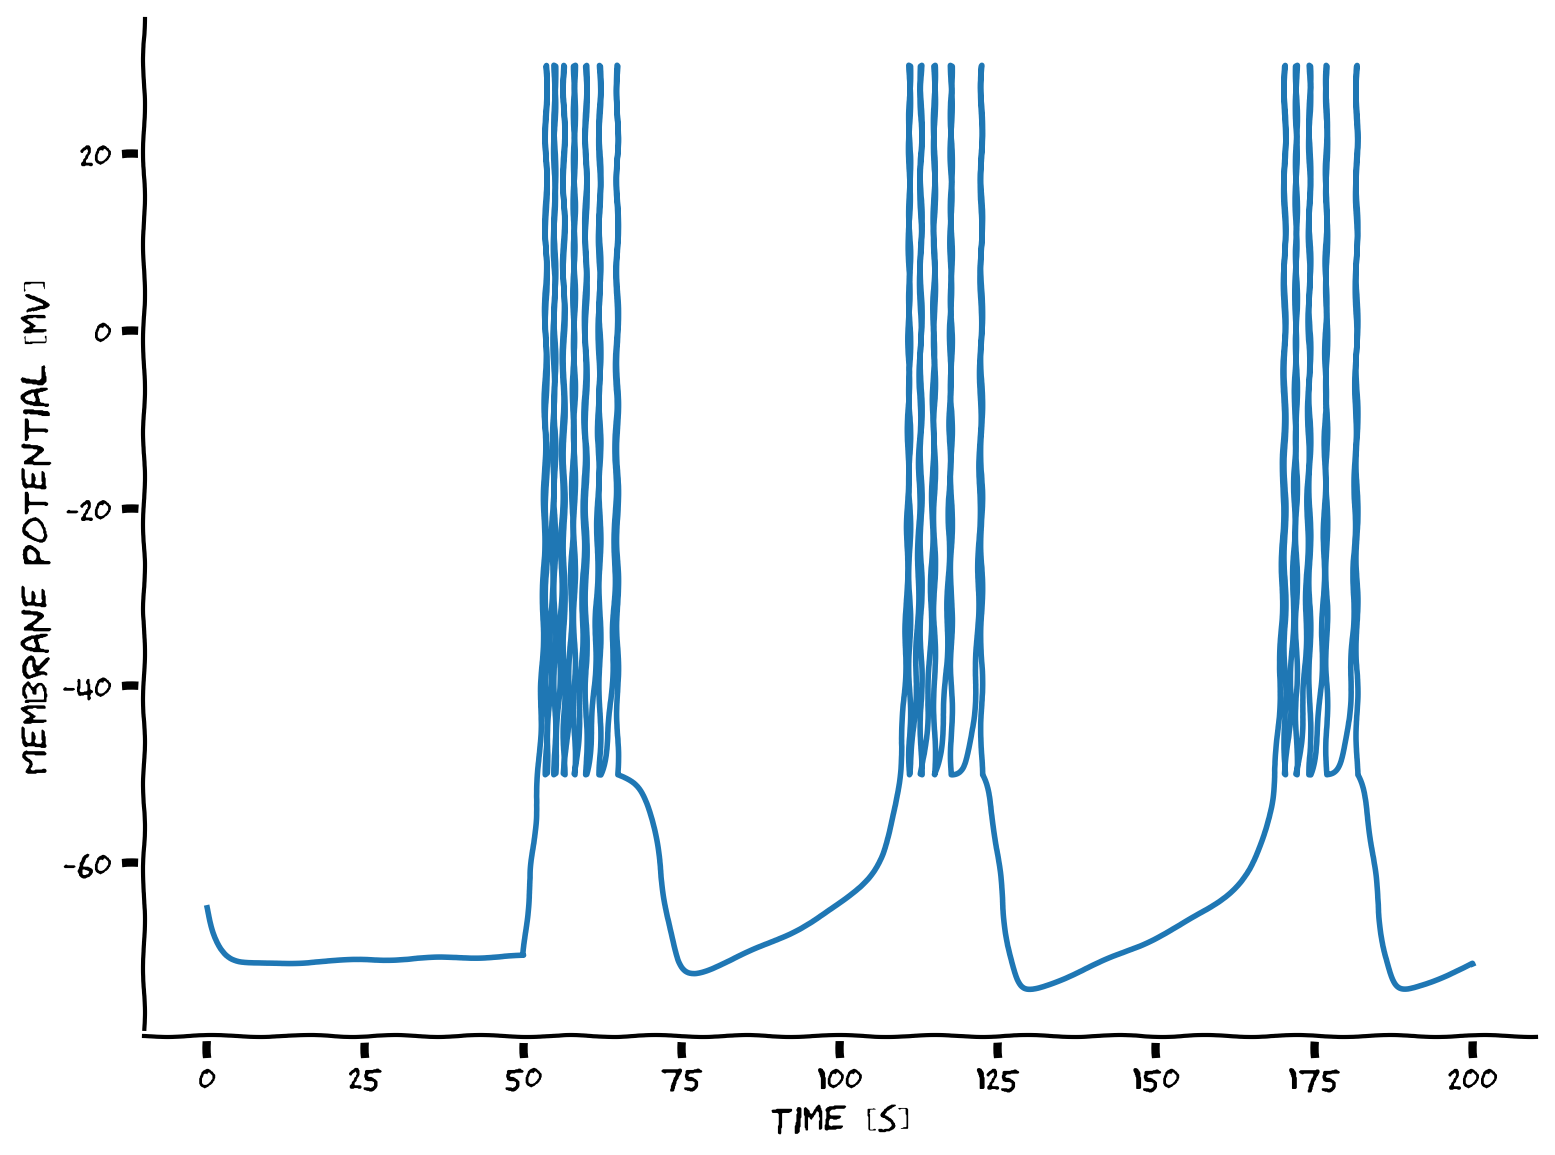

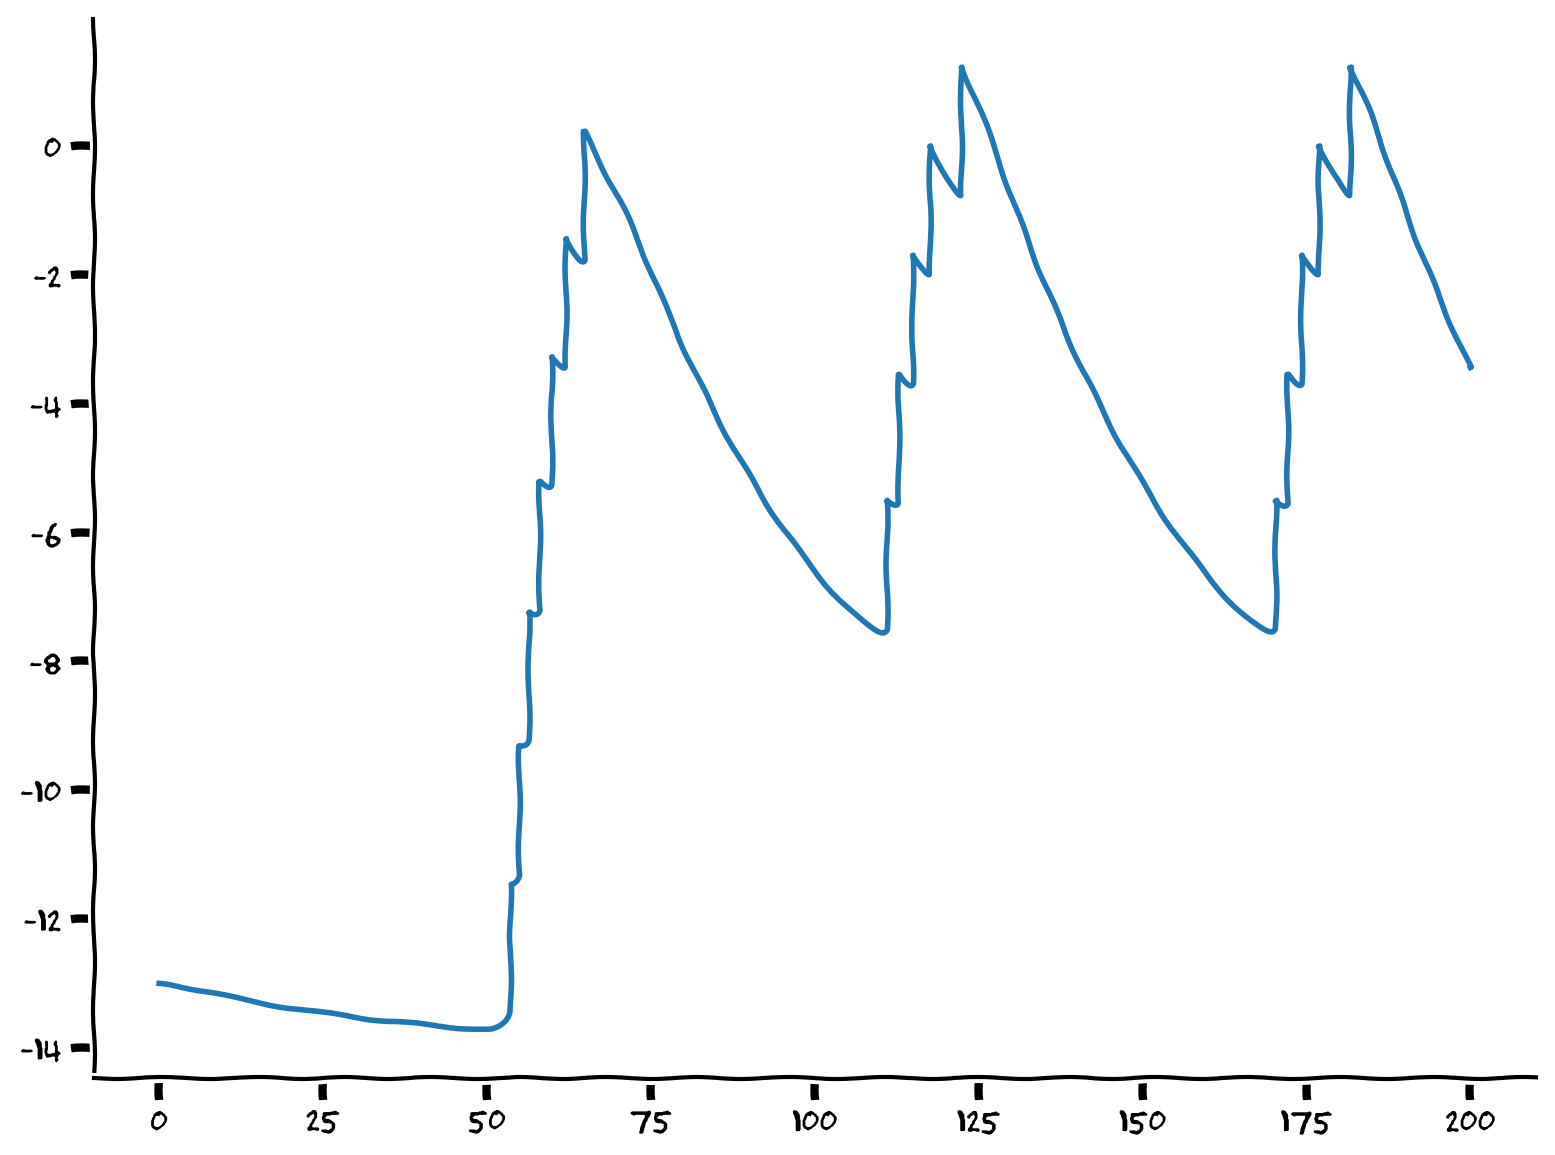

In [9]:
def izhikevich(input_current,t, a = 0.02, b= 0.2, c = -50, d = 2, thresh = 30 ):

    """

    Authors : Flo Blondiaux

    Simulate the Izhikevich model in response to an external input current

    Args:

      input_current   : Vector containing the input current [A].
      t               : Time vector expressed in [ms]

    Returns:
      u               : membrane potential [V]
      ts              : spike times [s]

    """

    ########################

    #### Your code here ####

    ########################
    v = np.zeros_like(t)
    u = np.zeros_like(t)
    dt = t[1]-t[0]
    v[0] = -65
    u[0] = b*v[0]
    for i in range(len(t)-1):
        v[i+1] = v[i]+dt*(0.04*v[i]**2+5*v[i]+140-u[i]+input_current[i])
        u[i+1] = u[i]+dt*(a*(b*v[i]-u[i]))
        if v[i+1]>=thresh:
            v[i+1]=c
            u[i+1]=u[i+1]+d
    return v,u

t_max = 200000e-3   # second
dt = .1e-3       # second
t_range = np.arange(0,t_max,dt)
input_current = np.ones_like(t_range)*10
input_current[0:500000] = 0
v,u = izhikevich(input_current, t_range)
with plt.xkcd():
  plt.plot(t_range,v)
  plt.ylabel('Membrane potential [mV]')
  plt.xlabel('Time [s]')
  plt.show()
  plt.plot(t_range,u)
  plt.show()
  #plot here

*Example output:*


<img alt='Solution hint' align='left' width=413 height=300 src=https://raw.githubusercontent.com/fblondiaux/LGBIO2072-2020/master/Images/TP1-Ex8.png>

Explore the influence of the different parameters using the following widget

In [ ]:
my_layout.width = '450px'
@widgets.interact(
    a=widgets.FloatSlider(0.02, min=0.01, max=.15, step=.01, layout=my_layout),
    b=widgets.FloatSlider(0.2, min=.10, max=.35, step=.01, layout=my_layout),
    c = widgets.FloatSlider(-50, min=-75, max=-40, step=2, layout=my_layout),
    d = widgets.FloatSlider(2, min=0.05, max=10, step=0.05, layout=my_layout)
)

def test_params(a =0.02, b= 0.2, c=-50, d=2):

    t_max = 200000e-3   # second
    dt = .1e-3       # second
    t_range = np.arange(0,t_max,dt)
    input_current = np.ones_like(t_range)*10
    input_current[0:500000] = 0
    v,u = izhikevich(input_current, t_range,a,b,c,d)

    fig, axs = plt.subplots(2)
    axs[0].plot(t_range,v)
    axs[0].set(title = "Membrane potential", ylabel = "u [mV]")
    axs[1].plot(t_range,u)
    axs[1].plot(t_range,u)
    axs[1].set(title = "Membrane recovery variable")
    plt.show()

### Exercise 8

Implement two types of neurons from the following list: Regular spiking (RS), Intrinsically bursting (IB), fast spiking (FS), thalamo-cortical (TC); resonator (RZ), low-threshold spiking (LTS). The example was a chattering neuron. More information can be obtained here: Details can be found here: https://www.izhikevich.org/publications/spikes.pdf

In [ ]:
#Implement the two kind of neurons here

---
## Bonus Section 1: Orenstein-Uhlenbeck Process

When a neuron receives spiking input, the synaptic current is Shot Noise – which is a kind of colored noise and the spectrum of the noise determined by the synaptic kernel time constant. That is, a neuron is driven by colored noise and not GWN.

We can model colored noise using the Ornstein-Uhlenbeck process - filtered white noise.

-> code this exercise [here](https://compneuro.neuromatch.io/tutorials/W2D3_BiologicalNeuronModels/student/W2D3_Tutorial1.html?highlight=leak%20integrate%20fire#bonus)

---
## Bonus Section 2: Generalized Integrate-and-Fire models

LIF model is not the only abstraction of real neurons. If you want to learn about more realistic types of neuronal models, watch a Bonus Video!

Click [here](https://compneuro.neuromatch.io/tutorials/W2D3_BiologicalNeuronModels/student/W2D3_Tutorial1.html?highlight=leak%20integrate%20fire#bonus-section-2-generalized-integrate-and-fire-models) for the video.